## Intro to Machine Learning and Deep learning

The goal of this assignment is to familiarize with the linear regression methods:

1. Repeat the previous jupyter notebook using the diabetes database
   ```python
   ...
   import mean_squared_error, r2_score
   # load the diabetes dataset
   diabetes_X, diabetes_Y = datasets.load(return_X_y=True)
   ```
2. Find labels and use them to build a linear classifier
3. Generate the $\bm{\tilde{X}}$ augmented samples and the $\bm{Y}$ labels and build the classifier.
4. Use a threshold to decide what are the labels in the data.
5. Then use the following $\verb+linear_model+$ package from $\verb+sklearn+$:
    ```python
    from sklearn import linear_model
    ```
6. Fit the X and Y using the instruction:
   ```python
   # Create a linear regression
   object regr = linear_model.LinearRegression()
   # Train the model using the training sets
   regr.fit(diabetes_X_train, diabetes_Y_train)
   # Make predictions using the testing
   set diabetes_Y_pred = regr.predict(diabetes_X_test)
   ```
7. Finally, compare both methods and provide a discussion.
---

## Data set aquisition

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn import datasets
from sklearn.model_selection import train_test_split

import scipy as sp
from scipy.stats import norm

Import the [_diabetes_ dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) from `sklearn` 

In [72]:
diabetes_X, diabetes_Y = datasets.load_diabetes(return_X_y=True) #,as_frame=True,scaled=False

we need to remap the feature dataset as a 2 dimentional numpy array

In [73]:
diabetes_Y = np.array([diabetes_Y]).T
diabetes_Y.shape
n_samples, n_features = diabetes_X.shape

observe that each row of the `diabetes_X` array is the data for one person, that is, one _observation_.

In [74]:
diabetes_X[1,:]

array([-0.00188202, -0.04464164, -0.05147406, -0.02632753, -0.00844872,
       -0.01916334,  0.07441156, -0.03949338, -0.06833155, -0.09220405])

### 2. Data labeling

---

It's clear that each row represents an element of the input vector space, hence our problem can be labeled as a multidimentional classification. To formulate the labels for the _feature_ dataset $Y\equiv$`diabetes_Y`, we need to analyze it further. First, from the dataset documentation we identify that $Y$ is described as _"a quantitative **measure** of disease **progression** one year after baseline"_. Thereby a possible choice for the label set,$\mathcal{L}$,can be a _qualitative meassure of disease progression_ (duh):
\begin{equation*}
\mathcal{A} := \left\lbrace \text{Low}, \text{Moderate},..., \text{High}, \text{Outstanding}\right\rbrace.
\end{equation*} .
Notice that there is an underlying problem: determine the _"granularity"_ of the label set, i.e. determine the number of classes. 
In order to determine the search space partitioning for the proposed dataset, assume that $Y\sim \mathcal{N}\left(\mu_Y,\,\sigma_Y^{2}\right)$.

In [75]:
mu_Y = np.mean(diabetes_Y)
sigma_Y = np.sqrt(np.var(diabetes_Y))
mu_Y, sigma_Y

(152.13348416289594, 77.00574586945044)

Now, let us plot the data distribution

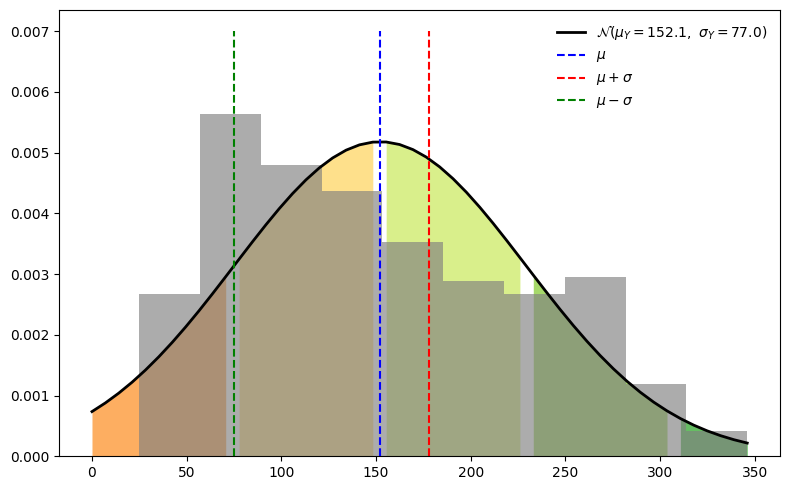

In [91]:
x = np.linspace(0, max(diabetes_Y))
diabetes_Y_pdf = sp.stats.norm.pdf(x,loc=mu_Y,scale=sigma_Y)
fig, ax = plt.subplots(figsize = (8, 5))
#ax.hist((diabetes_Y-mu_Y)/sigma_Y, density=True, bins='auto',histtype='bar',alpha=0.65,color='gray',cumulative=True)
ax.plot(x, diabetes_Y_pdf, lw = 2, color = 'k',  label = r'$\mathcal{N}\left( \mu_Y = %.1f,\  \sigma_Y = %.1f \right)$'%(mu_Y, sigma_Y))
#
ax.plot([[mu_Y],[mu_Y]],[[0],[0.007]], '--b', label = '$\mu$' )
ax.plot([[mu_Y+sigma_Y/3],[mu_Y+sigma_Y/3]],[[0],[0.007]], '--r',label = '$\mu+\sigma$' )
ax.plot([[mu_Y-sigma_Y],[mu_Y-sigma_Y]], [[0],[0.007]], '--g',label = '$\mu-\sigma$' )
ax.legend(loc='best', frameon=False)
# nice plot
#colors = ['c', 'r', 'b', 'g', ]
#colors = colors + list(reversed(colors))
colors = ['#d73027','#f46d43','#fdae61','#fee08b','#d9ef8b','#a6d96a','#66bd63','#1a9850']#['#003c30','#01665e','#35978f','#80cdc1','#c7eae5','#f6e8c3','#dfc27d','#bf812d','#8c510a','#543005']

for i, color in zip(range(-4, 4), colors):
    low = mu_Y + i * sigma_Y
    high = mu_Y + (i + 1) * sigma_Y
    matches=np.where(np.logical_and(x >= low, x <= high))
    plt.fill_between(
        x[matches],
        diabetes_Y_pdf[matches],
        color=color,
        #alpha=0.985,
        linewidth=0,
    )
    
ax.hist(diabetes_Y, density=True, bins='auto',histtype='bar',alpha=0.65,color='gray')
plt.tight_layout()    
plt.show()

We observe that the data is biased towards the lower values, resulting into an inadequate distribution fitting. Furthermore, the number of `auto` classes suggests a high number of qualitative labels. To simplify the problem we propose a 4 bins histogram, such that each _quantile_ is matched with the proposed label set $\mathcal{A}$. 
Notice that this label selection defines a _multiclass classification_, despite the complexity, one can always partition the space using the mean value $\mu_Y$ as threshold  and getting a binary label set $\mathcal{A}_{\text{bin}} := \left\lbrace \text{Poor}= \left\lbrace \text{Low}, \text{Moderate} \right\rbrace, \text{Good}=\left\lbrace \text{High}, \text{Outstanding} \right\rbrace\right\rbrace$.
However, as we're _young and res(t)/(k)less_, we'll try to perform a multiclass classification. We shall began by finding the quantiles for the feature class:

In [77]:
quantiles_mapping = np.percentile(diabetes_Y, [25, 50, 75])
quantiles_mapping

array([ 87. , 140.5, 211.5])

Furthermore, using **chatGPT** we get the following quantile-based labeling function:

In [78]:
def map_to_percentiles(values, n):
    """
    Map an array of values to their corresponding percentiles.

    Parameters:
    values (numpy.ndarray): Input array of values.
    n (int): Number of percentiles to calculate.

    Returns:
    numpy.ndarray: An array of percentiles corresponding to the input values.
    """
    # Calculate the percentiles
    percentiles = np.percentile(values, np.linspace(0, 100, n))

    # Map each value to its corresponding percentile
    percentile_mapping = np.digitize(values, percentiles)

    return percentile_mapping

Now we are ready to implement the linear classificator from leasson 1.
### Summary: 

  - The dataset $\bm{X}:=$`diabetes_x` is composed of $n:=$`442` normalized and centered samples.
  - Each  $\bm{x}^{(i)}\bm{X}$ is represented as a 10-dimensional ($d=10$) vector $\bm{x}^{(i)}\in\Reals^{10}.$
  - The input dataset $\bm{X}\subset\Reals{n\times d}$ has an `np.vstack`-ed form
    \begin{equation*} 
    \displaystyle
      \verb+diabetes_x+\equiv\bm{X}= 
        \begin{pmatrix} 
          x^{(1)}_1   & x^{(1)}_2   & \cdots & x^{(1)}_{d-1}   & x^{(1)}_d   \\
          x^{(2)}_1   & x^{(2)}_2   & \cdots & x^{(2)}_{d-1}   & x^{(2)}_d   \\ 
          \vdots      & \vdots      & \vdots & \vdots          & \vdots      \\
          x^{(n-1)}_1 & x^{(n-1)}_2 & \cdots & x^{(n-1)}_{d-1} & x^{(n-1)}_d \\ 
          x^{(n)}_1   & x^{(n)}_2   & \cdots & x^{(n)}_{d-1}   & x^{(n)}_d 
        \end{pmatrix} 
        =
        \begin{pmatrix}
          {\bm{x}^{(1)}}^{\intercal}   \\ 
          {\bm{x}^{(2)}}^{\intercal}   \\ 
          \vdots                       \\
          {\bm{x}^{(n-1)}}^{\intercal} \\ 
          {\bm{x}^{(n)}}^{\intercal}
        \end{pmatrix}
    \end{equation*}
  hence, it's straight forward to extend the input space $\tilde{\bm{X}}=\left(\bm{e}_{n\times 1}, \bm{X}\right)$, where $\Reals^{n}\ni \bm{e}_{n\times 1}:=\left(1, \cdots, 1\right)$ .
  -  The output/feature space is labeled using the $\mathcal{A}$ or $\mathcal{A}_\text{bin}$ sets and the `map_to_percentiles()` method.

## Leasson 1 approach

----
First, let us define the data extension procedure: 

In [79]:
extra_dimension = np.ones([n_samples,1])

In [92]:
X_tilde = np.hstack([extra_dimension, diabetes_X])
X_tilde.shape

(442, 11)

And then obtain the so-called extended _covariant matrix_ $C = \tilde{\bm{X}}^\intercal \tilde{\bm{X}}$

In [81]:
CovX = np.matmul(X_tilde.T, X_tilde)

Then the linear regressor weights arise as $C^{-1}\tilde{X}^{\intercal}\tilde{Y}$ 

### 1.- Binary classification

In [121]:
positive_progress_threshold = mu_Y# + sigma_Y/3
#diabetes_Y_labels_log = (-1)*np.not_equal(diabetes_Y >= positive_progress_threshold, True)+(diabetes_Y >= positive_progress_threshold)  
diabetes_Y_labels = np.sign(diabetes_Y-positive_progress_threshold)

In [83]:
W = np.matmul( np.linalg.inv(CovX) , np.matmul(X_tilde.T,diabetes_Y_labels) )
W

array([[-0.26244344],
       [-0.58235564],
       [-2.06024033],
       [ 5.30859138],
       [ 4.21430375],
       [-0.18390319],
       [-0.53780506],
       [-2.32003905],
       [-0.19802845],
       [ 5.53001466],
       [ 0.03406153]])

In [84]:
W.shape

(11, 1)

In [85]:
estimated_value = np.matmul(X_tilde, W)
estimated_value

array([[ 2.68218704e-01],
       [-1.08755399e+00],
       [-8.71584516e-02],
       [-1.48360519e-01],
       [-4.80549081e-01],
       [-6.70754142e-01],
       [-9.80680666e-01],
       [-4.62861448e-01],
       [-2.48686273e-01],
       [ 3.91708041e-01],
       [-7.59029603e-01],
       [-8.50605315e-01],
       [-6.33378204e-01],
       [-1.17554481e-01],
       [-7.50315145e-01],
       [ 1.01200129e-01],
       [ 3.99060700e-01],
       [ 9.72992814e-02],
       [-3.74921061e-01],
       [-5.43531219e-01],
       [-6.54824095e-01],
       [-8.37355258e-01],
       [-5.68261841e-01],
       [ 9.35267202e-01],
       [-1.53517804e-01],
       [-3.30566091e-01],
       [-8.43400076e-01],
       [-8.49832010e-02],
       [-5.82776309e-01],
       [ 1.10986644e-01],
       [-1.71184935e-01],
       [-1.14158011e+00],
       [ 6.34625488e-01],
       [-7.68906850e-01],
       [-1.06295143e+00],
       [-9.54684520e-01],
       [ 4.02656556e-01],
       [-2.88668210e-01],
       [ 7.9

In [86]:
predicted_labels  = np.sign(estimated_value)
predicted_labels

array([[ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
      

In [87]:
prediction_error = predicted_labels- diabetes_Y_labels
prediction_error.shape
np.hstack([prediction_error, predicted_labels, diabetes_Y_labels])

array([[ 2.,  1., -1.],
       [ 0., -1., -1.],
       [ 0., -1., -1.],
       ...,
       [ 0., -1., -1.],
       [ 0.,  1.,  1.],
       [ 0., -1., -1.]])

In [88]:
squared_performance_error = np.dot(prediction_error.T,prediction_error)/(2*n_samples)
squared_performance_error

array([[0.4479638]])

In [120]:
sum(prediction_error != 0)

array([99])

In [ ]:
sum(prediction_error != 0)/n_samples

## Systematic approach

---

Ok, so we're ready to begin. As the supervised learning training processes dictates, we need to partition our input data into training and testing datasets, for that purpose we'll be using the  `train_test_split(X,Y, train_size)` from the  `sklearn.model_selection` library.

![](image.png)

*Figure 1. Supervised Training Process. Recovered from the course notes.*

In [106]:
diabetes_X_train, diabetes_X_test, diabetes_Y_train, diabetes_Y_test = train_test_split(diabetes_X, diabetes_Y_labels, train_size=0.2)

In order to label our training dataset, let us plot the feature dataset scattering

In [109]:
# Create a linear regression
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_Y_train)
# Make predictions using the testing
diabetes_Y_pred = regr.predict(diabetes_X_test)
diabetes_Y_pred_label = np.sign(diabetes_Y_pred)

array([[-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
      

In [114]:
diabetes_label_prediction_error = diabetes_Y_test - diabetes_Y_pred_label
diabetes_label_prediction_error

array([[ 0.],
       [-2.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-2.],
       [ 0.],
       [ 0.],
       [-2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-2.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 2.],
       [-2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-2.],
       [-2.],
       [ 0.],
       [-2.],
      

In [113]:
J = np.dot(diabetes_label_prediction_error.T,diabetes_label_prediction_error)
#diabetes_label_prediction_error.shape[0]


354

In [116]:
J/(diabetes_label_prediction_error.shape[0])

array([[0.94915254]])

In [118]:
sum(diabetes_label_prediction_error != 0)

array([84])

In [119]:
sum(diabetes_label_prediction_error != 0)/diabetes_label_prediction_error.shape[0]

array([0.23728814])